In [1]:
##IMPORTS
#Basics
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os # create directories in the local filesystem
from tqdm import tqdm # plot progress bars
import plotly.express as px

#PyTorch
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import  DataLoader
from torch import nn


import torch.optim as optim
import torch.nn.functional as F

#Pytoprch lightning


#For Optuna (Hyperparameters search)
import optuna
from optuna.integration import PyTorchLightningPruningCallback

#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# For latent space exploration
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Models definitions and training models
import model


C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set seeds for reproducibility (PyTorch, Python, Numpy)
matricola = 2013031
torch.manual_seed(matricola)
random.seed(matricola)
np.random.seed(matricola)


# Import the data

In [3]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=False)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=False)


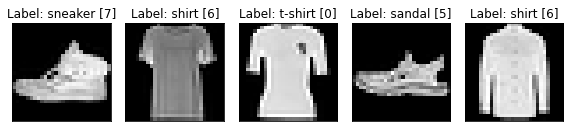

In [4]:
### Plot some sample
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(1, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('./Img/clothe_samples.svg', format='svg')
plt.tight_layout()

In [5]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [6]:
batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


# Implement autoencoder

**2 pt - Implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and some examples of image reconstruction; explore advanced optimizers and regularization methods**


In [7]:
encoded_space_dim = 2
max_epochs        = 10
learning_rate     = 1e-3
regularization    = 0.
nf                = 8

In [8]:
# Initialize the autoencoder
AE = model.Autoencoder(encoded_space_dim,nf)


In [9]:
### Define the loss function for reconstruction
loss_fn = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': AE.encoder.parameters()},
    {'params': AE.decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=regularization)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
AE.to(device)


Selected device: cpu


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=288, out_features=64, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
    (4): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (8): ReLU(inplac

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 1/10
AVERAGE TRAIN LOSS: 0.09352531284093857
AVERAGE TEST LOSS: 0.04421302676200867


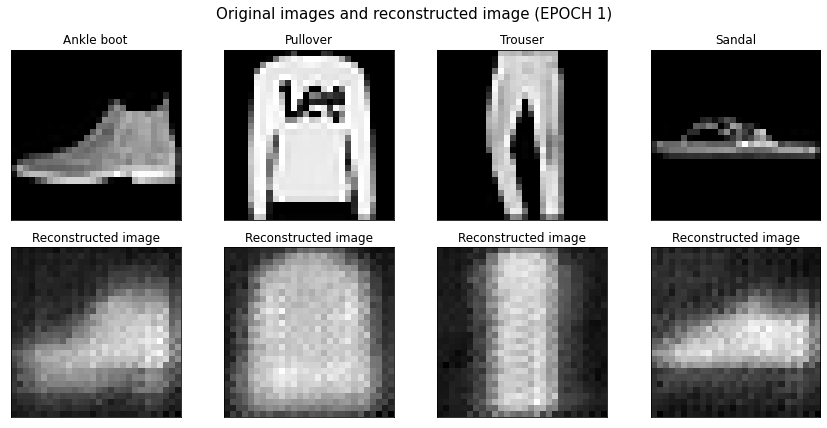

 10%|█         | 1/10 [00:14<02:09, 14.43s/it]

EPOCH 2/10
AVERAGE TRAIN LOSS: 0.0408201739192009


 20%|██        | 2/10 [00:31<02:05, 15.73s/it]

AVERAGE TEST LOSS: 0.038555633276700974
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.03699951991438866


 30%|███       | 3/10 [00:48<01:55, 16.52s/it]

AVERAGE TEST LOSS: 0.03600844740867615
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.03513478860259056


 40%|████      | 4/10 [01:05<01:40, 16.72s/it]

AVERAGE TEST LOSS: 0.03471613675355911
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.034103889018297195


 50%|█████     | 5/10 [01:23<01:25, 17.15s/it]

AVERAGE TEST LOSS: 0.03409736976027489
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.0333879292011261
AVERAGE TEST LOSS: 0.03327097371220589


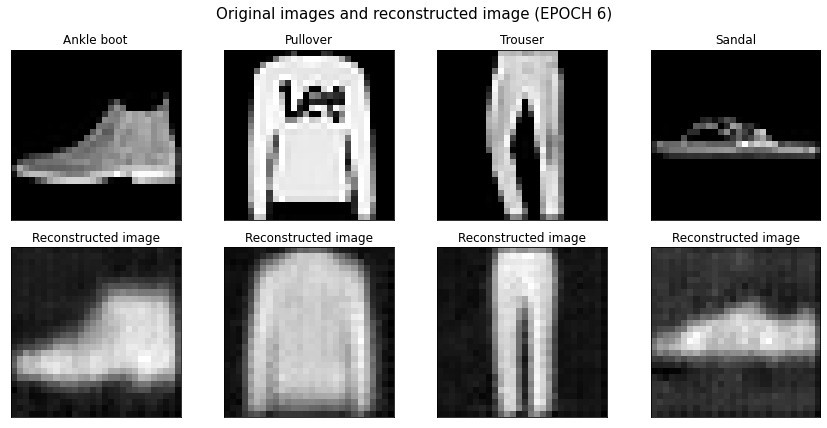

 60%|██████    | 6/10 [01:43<01:12, 18.17s/it]

EPOCH 7/10
AVERAGE TRAIN LOSS: 0.03276354819536209


 70%|███████   | 7/10 [02:04<00:57, 19.21s/it]

AVERAGE TEST LOSS: 0.032610319554805756
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.03211339935660362


 80%|████████  | 8/10 [02:26<00:39, 19.98s/it]

AVERAGE TEST LOSS: 0.03195946663618088
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.0316300243139267


 90%|█████████ | 9/10 [02:46<00:20, 20.00s/it]

AVERAGE TEST LOSS: 0.03170430660247803
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.031196417286992073


100%|██████████| 10/10 [03:08<00:00, 18.86s/it]

AVERAGE TEST LOSS: 0.031180649995803833


In [10]:
train_loss, test_loss = AE.training_cycle(device,
                                train_dataloader,
                                test_dataloader,
                                loss_fn,
                                optim,
                                max_epochs,
                                test_dataset,
                                encoded_space_dim,
                                plot = True,
                                keep_plots = False,
                                keep_model=False,
                                verbose=True)

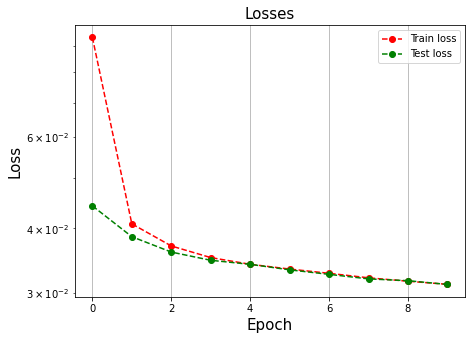

In [11]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train_loss, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test_loss, linestyle='--', marker='o', color='g', label='Test loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.savefig('./imgs/classification/losses.svg', format='svg')
plt.show()

# Optimize autoencoder parameters

**1 pt - optimize hyperparameters using grid/random search or automatic tuning tools (e.g., Optuna)**

In [13]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


Selected device: cpu


In [14]:
def objective(trial):
    max_epochs = 8
    
    # Parameters for the search
    nf                     = trial.suggest_categorical("nf", [4,8,16])
    encoded_space_dim      = trial.suggest_categorical("encoded_space_dim", [2,5,10])
    optimizer_name         = trial.suggest_categorical('optimizer_name',["SGD", "Adam"])
    lr                     = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    regularization         = trial.suggest_loguniform("regularization", 1e-5, 1e-1)
    
    
    ### Initialize both network
    AE = model.Autoencoder(encoded_space_dim,nf)
    AE.to(device)
 
    ### Define the loss function
    loss_fn = nn.MSELoss()
    
    #Define the optimizer
    optimizer = getattr(torch.optim,optimizer_name)(AE.parameters(), lr=lr, weight_decay=regularization)
    
    #The bad thing of this simple approach is that we only consider the last epoch test loss as the valid one.
    train, test = AE.training_cycle(device,
                                train_dataloader,
                                test_dataloader,
                                loss_fn,
                                optimizer,
                                max_epochs,
                                test_dataset,
                                encoded_space_dim,
                                plot       = False,
                                keep_plots = False,
                                keep_model =False,
                                verbose    =False)
 
    return test[-1]

In [15]:
#Define the study
study = optuna.create_study(study_name="no_pruning", direction="minimize")
study.optimize(objective, n_trials=200, timeout=25000) #6 hours

[I 2022-07-10 17:52:41,539] A new study created in memory with name: no_pruning
100%|██████████| 8/8 [02:29<00:00, 18.72s/it]
[I 2022-07-10 17:55:11,304] Trial 0 finished with value: 0.2816488742828369 and parameters: {'nf': 4, 'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 1.9822650353972598e-05, 'regularization': 0.0009313717262532162}. Best is trial 0 with value: 0.2816488742828369.
100%|██████████| 8/8 [02:29<00:00, 18.73s/it]
[I 2022-07-10 17:57:41,133] Trial 1 finished with value: 0.02941051498055458 and parameters: {'nf': 4, 'encoded_space_dim': 5, 'optimizer_name': 'Adam', 'lr': 0.00023184626408254933, 'regularization': 0.00023461183580817115}. Best is trial 1 with value: 0.02941051498055458.
100%|██████████| 8/8 [03:03<00:00, 23.00s/it]
[I 2022-07-10 18:00:45,123] Trial 2 finished with value: 0.08797254413366318 and parameters: {'nf': 8, 'encoded_space_dim': 5, 'optimizer_name': 'Adam', 'lr': 0.03347054442106418, 'regularization': 0.0018162505220579077}. Best is tria

100%|██████████| 8/8 [06:03<00:00, 45.44s/it]
[I 2022-07-10 19:28:37,193] Trial 25 finished with value: 0.01659712940454483 and parameters: {'nf': 16, 'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.003413571604927939, 'regularization': 4.218766660848795e-05}. Best is trial 24 with value: 0.014877090230584145.
100%|██████████| 8/8 [05:42<00:00, 42.76s/it]
[I 2022-07-10 19:34:19,281] Trial 26 finished with value: 0.016503412276506424 and parameters: {'nf': 16, 'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0030658852677419917, 'regularization': 3.0713765350251446e-05}. Best is trial 24 with value: 0.014877090230584145.
100%|██████████| 8/8 [04:53<00:00, 36.70s/it]
[I 2022-07-10 19:39:12,939] Trial 27 finished with value: 0.12414916604757309 and parameters: {'nf': 16, 'encoded_space_dim': 10, 'optimizer_name': 'SGD', 'lr': 0.0004554418940782051, 'regularization': 1.044012250854571e-05}. Best is trial 24 with value: 0.014877090230584145.
100%|██████████| 8/8 [05:45<

100%|██████████| 8/8 [04:36<00:00, 34.61s/it]
[I 2022-07-10 21:34:03,305] Trial 50 finished with value: 0.02137705683708191 and parameters: {'nf': 16, 'encoded_space_dim': 5, 'optimizer_name': 'Adam', 'lr': 0.00033339269250459345, 'regularization': 1.60717021120806e-05}. Best is trial 24 with value: 0.014877090230584145.
100%|██████████| 8/8 [04:29<00:00, 33.72s/it]
[I 2022-07-10 21:38:33,068] Trial 51 finished with value: 0.015358984470367432 and parameters: {'nf': 16, 'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0015014228507772712, 'regularization': 1.557120983017292e-05}. Best is trial 24 with value: 0.014877090230584145.
100%|██████████| 8/8 [05:12<00:00, 39.09s/it]
[I 2022-07-10 21:43:45,839] Trial 52 finished with value: 0.01825355552136898 and parameters: {'nf': 16, 'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0008627989476916086, 'regularization': 2.55232726292071e-05}. Best is trial 24 with value: 0.014877090230584145.
100%|██████████| 8/8 [04:56<0

100%|██████████| 8/8 [04:45<00:00, 35.71s/it]
[I 2022-07-10 23:39:27,268] Trial 75 finished with value: 0.0234986525028944 and parameters: {'nf': 16, 'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.01691210318911972, 'regularization': 1.7553287155593543e-05}. Best is trial 73 with value: 0.014806253835558891.
100%|██████████| 8/8 [04:39<00:00, 34.91s/it]
[I 2022-07-10 23:44:06,544] Trial 76 finished with value: 0.03190635144710541 and parameters: {'nf': 16, 'encoded_space_dim': 2, 'optimizer_name': 'Adam', 'lr': 0.003970080495574638, 'regularization': 3.80844948023286e-05}. Best is trial 73 with value: 0.014806253835558891.
100%|██████████| 8/8 [04:26<00:00, 33.34s/it]
[I 2022-07-10 23:48:33,309] Trial 77 finished with value: 0.015752535313367844 and parameters: {'nf': 16, 'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0014440174948030069, 'regularization': 2.2618159378530155e-05}. Best is trial 73 with value: 0.014806253835558891.
100%|██████████| 8/8 [04:13<00:

In [16]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 92
Best trial:
  Value: 0.014767616987228394
  Params: 
    nf: 16
    encoded_space_dim: 10
    optimizer_name: Adam
    lr: 0.0044543568366006816
    regularization: 1.0018337530698803e-05


In [17]:
optuna.visualization.plot_param_importances(study)

In [45]:
optuna.visualization.plot_contour(study, params=['lr','regularization'])

## Re train best model 

In [19]:
learning_rate       = trial.params['lr']
encoded_space_dim   = trial.params["encoded_space_dim"]
regularization_term = trial.params["regularization"]
nf                  = trial.params["nf"]
n_epochs = 50 

In [20]:
AE = model.Autoencoder(encoded_space_dim,nf)

In [21]:
### Define the loss function
loss_fn = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': AE.encoder.parameters()},
    {'params': AE.decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=regularization_term)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
AE.to(device)

Selected device: cpu


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=576, out_features=64, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=576, bias=True)
    (3): ReLU(inplace=True)
    (4): Unflatten(dim=1, unflattened_size=(64, 3, 3))
    (5): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (8): ReLU(i

  0%|          | 0/50 [00:00<?, ?it/s]

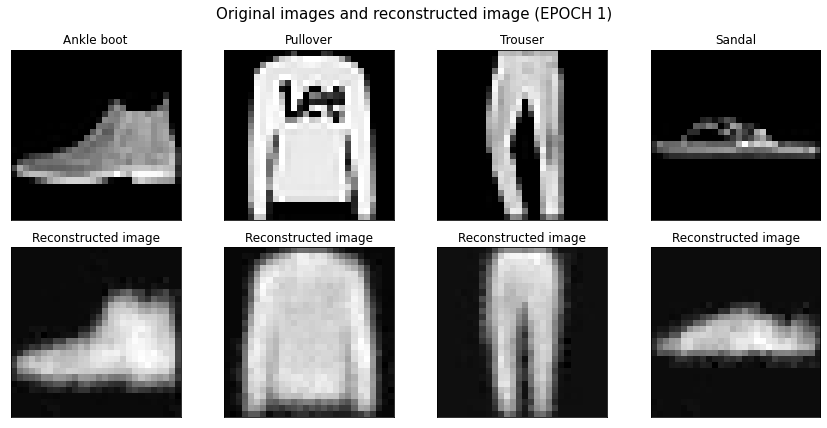

 10%|█         | 5/50 [02:46<24:53, 33.18s/it]

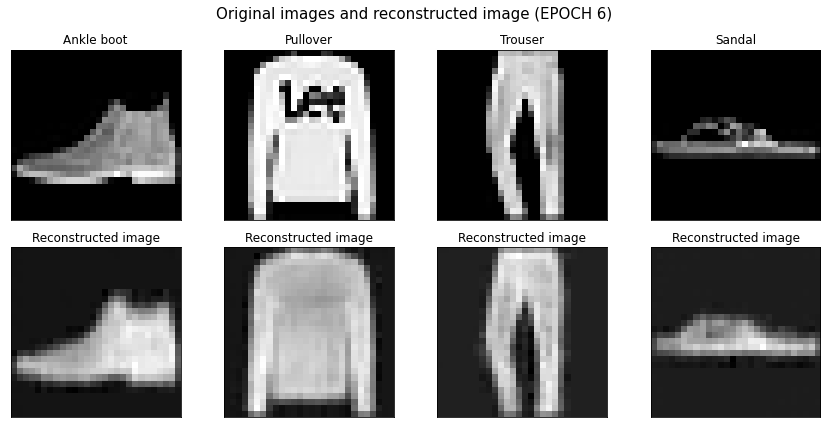

 20%|██        | 10/50 [07:21<37:27, 56.18s/it]

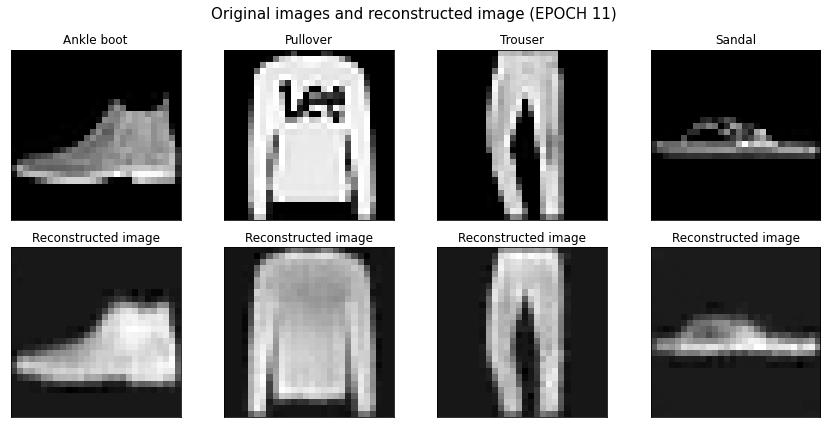

 30%|███       | 15/50 [13:06<39:07, 67.06s/it]

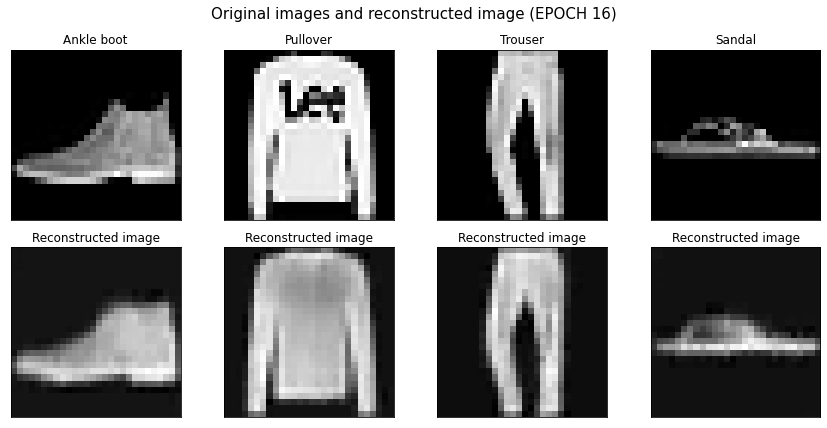

 40%|████      | 20/50 [18:51<34:14, 68.49s/it]

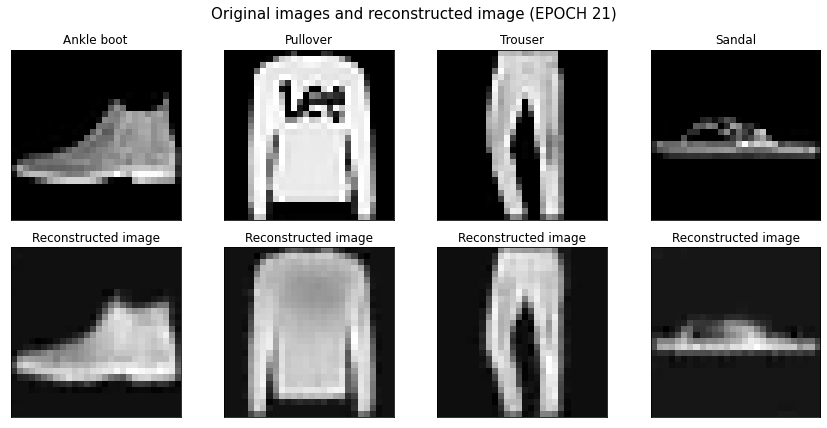

 50%|█████     | 25/50 [24:03<26:16, 63.06s/it]

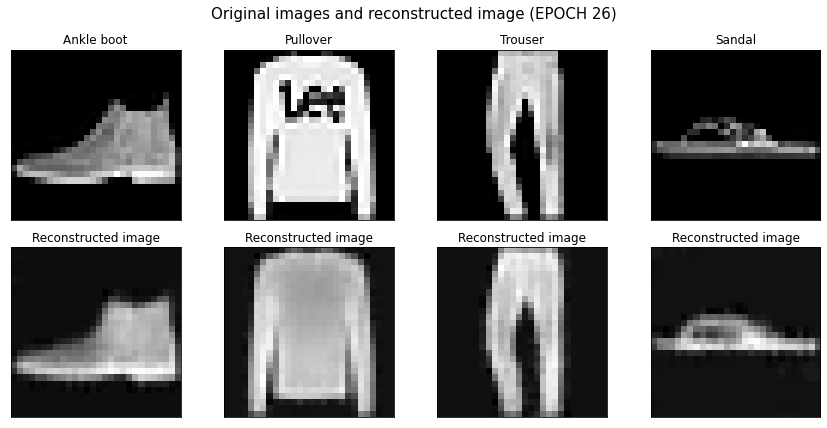

 60%|██████    | 30/50 [29:25<21:29, 64.49s/it]

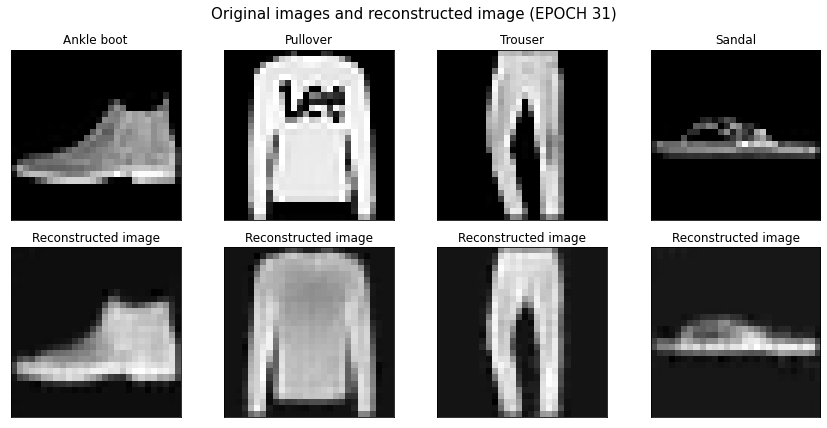

 70%|███████   | 35/50 [35:11<17:04, 68.27s/it]

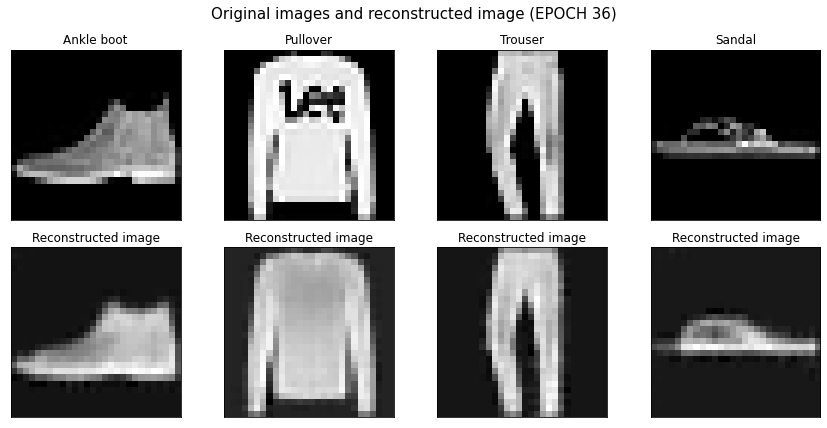

 80%|████████  | 40/50 [40:29<10:32, 63.22s/it]

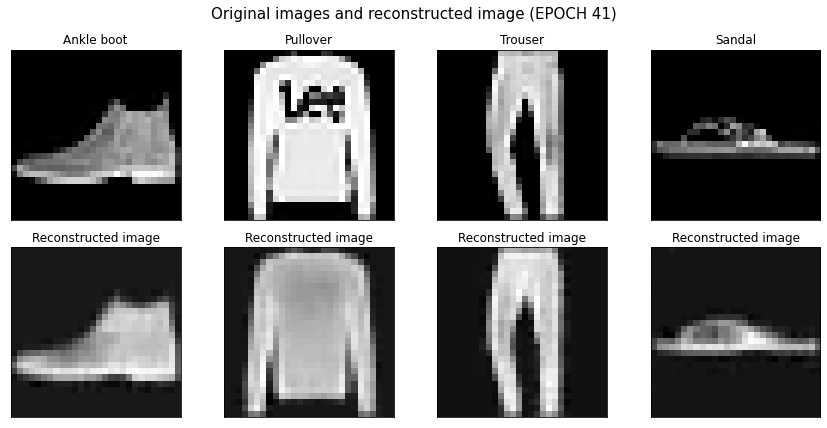

 90%|█████████ | 45/50 [45:29<05:01, 60.21s/it]

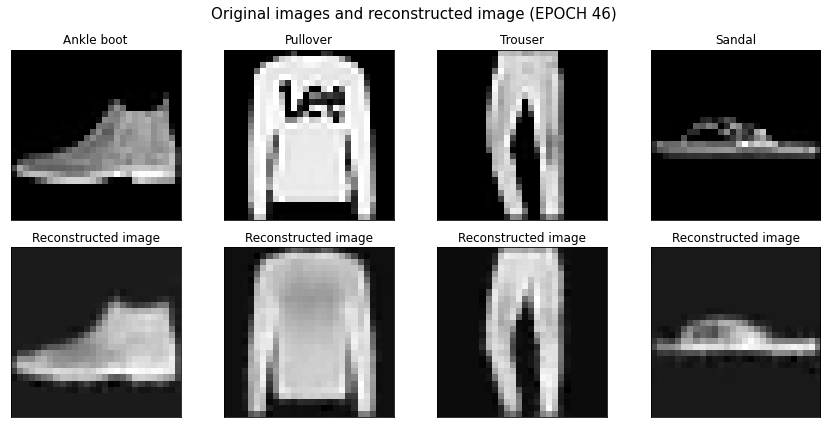

100%|██████████| 50/50 [50:08<00:00, 60.16s/it]


In [22]:
train_loss, test_loss = AE.training_cycle(device,
                                train_dataloader,
                                test_dataloader,
                                loss_fn,
                                optim,
                                n_epochs,
                                test_dataset,
                                encoded_space_dim,
                                plot = True,
                                keep_plots = True,
                                keep_model=True,
                                verbose = False)

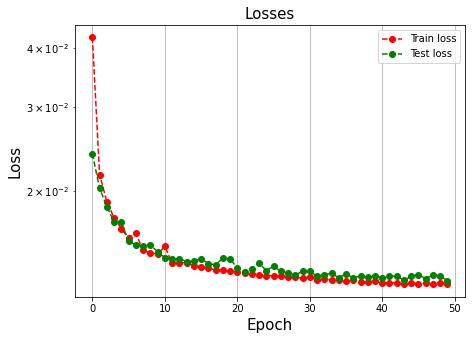

In [23]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train_loss, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test_loss, linestyle='--', marker='o', color='g', label='Test loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
plt.savefig('./Img/best_model_losses.svg', format='svg')
plt.show()

# Latent space exploration

**2 pt - explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes**

## Retrieve the encoded vector for each image in the test set

In [25]:
AE = model.Autoencoder(trial.params["encoded_space_dim"],trial.params["nf"])

In [26]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


In [27]:
# Load network parameters
AE.encoder.load_state_dict(torch.load('Models/encoder_params.pth'))
AE.decoder.load_state_dict(torch.load('Models/decoder_params.pth'))

<All keys matched successfully>

In [28]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    AE.encoder.eval()
    with torch.no_grad():
        encoded_img  = AE.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:04<00:00, 2121.80it/s]


In [29]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0            0.438934        -9.544698         0.691862         0.587537   
1           24.719736        -1.373401        -5.122802        -5.408451   
2            2.487359        12.192477         1.675079         2.278208   
3            0.109244        10.023418         0.914502         4.449475   
4           11.236722         5.118455        -1.659139        -3.748247   
...               ...              ...              ...              ...   
9995         5.939764       -10.588893         3.690440         7.757813   
9996         0.386757         6.378922        -2.380465         3.505022   
9997        10.863325         5.364223         1.229450        -2.533292   
9998        -1.012315         8.781677        -3.336840        10.752015   
9999         2.411476        -5.685751         0.298681         0.817109   

      Enc. Variable 4  Enc. Variable 5  Enc. Variable 6  Enc. Variable 7  \
0           -8.999812         1.565566         0.543079        -4.545929   
1            4.973155        -2.136520         3.868426        13.047525   
2           -7.148590         0.359172         7.951438         6.136413   
3           -0.472556        -1.014738         4.323166         1.189742   
4           -0.913976        -1.260719        -4.399493        14.156168   
...               ...              ...              ...              ...   
9995       -10.236737        -4.582530        -1.298204         1.162051   
9996        -0.023524        -0.313897         2.408096         0.326361   
9997        -7.728462        -3.882240       -11.225797        -4.931135   
9998        -3.980064        -1.002458         3.988175         0.971135   
9999        -6.635704         2.889619        -0.492225        -0.207113   

      Enc. Variable 8  Enc. Variable 9  label  
0          -11.418459         0.432521      9  
1           -7.508611        -2.155177      2  
2            4.989692         9.622150      1  
3            4.889334         5.485851      1  
4           -3.154456         0.320478      6  
...               ...              ...    ...  
9995       -21.622599         3.063141      9  
9996         3.401619         3.239870      1  
9997         2.909841         2.567786      8  
9998         5.688990         7.686697      1  
9999        -1.328510        -0.184414      5  

[10000 rows x 11 columns]

## PCA

In [30]:
pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)


In [31]:
pca_df = pd.DataFrame(encoded_samples_reduced_PCA)
pca_df['label'] = encoded_samples.label 


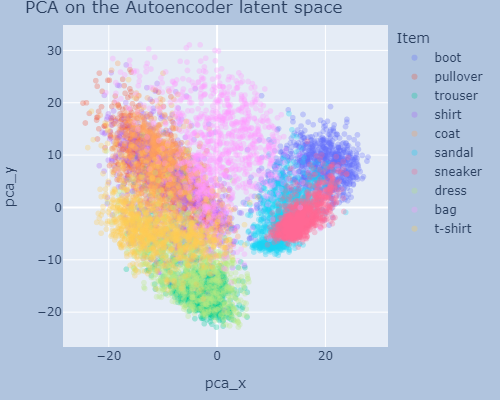

In [32]:
fig = px.scatter(pca_df, x=0, y=1, color=[label_names[l] for l in encoded_samples.label.to_numpy()],
                 opacity=0.3,
                 width=500,
                 height=400,
                 title="PCA on the Autoencoder latent space",
                labels={"0":"pca_x","1":"pca_y","color":"Item"})

fig.update_layout(
    margin=dict(l=20, r=20, t=25, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show("png")
fig.write_image("Img/CAE_PCA.svg")

## TSNE

In [33]:
tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)


C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [34]:
tsne_df = pd.DataFrame(encoded_samples_reduced_TSNE)
tsne_df['label'] = encoded_samples.label 


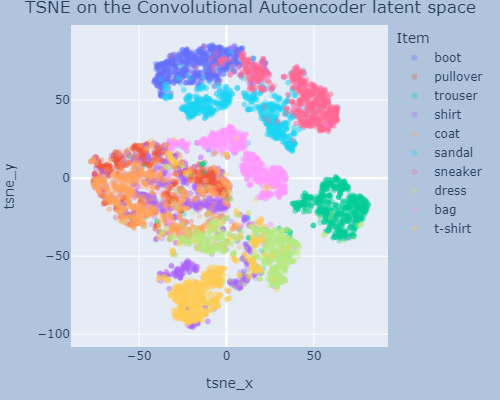

In [35]:
fig = px.scatter(tsne_df, x=0, y=1, color=[label_names[l] for l in encoded_samples.label.to_numpy()],
                 opacity=0.3,
                 width=500,
                 height=400,
                 title="TSNE on the Convolutional Autoencoder latent space",
                labels={"0":"tsne_x","1":"tsne_y","color":"Item"})

fig.update_layout(
    margin=dict(l=20, r=20, t=25, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show("png")
fig.write_image("Img/CAE_TSNE.svg")

## Sample generation

For the sample generation I will go to a model with a latent space dimension equal to two.

In [36]:
encoded_space_dim = 2
max_epochs     = 20
learning_rate  = 0.0067
regularization = 0.
nf             = 8

In [37]:
# Initialize the autoencoder
AE_2 = model.Autoencoder(encoded_space_dim,nf)

In [38]:
### Define the loss function for reconstruction
loss_fn = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': AE_2.encoder.parameters()},
    {'params': AE_2.decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=regularization)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
AE_2.to(device)

Selected device: cpu


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=288, out_features=64, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
    (4): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (8): ReLU(inplac

In [39]:
_,_ =AE_2.training_cycle(device,
                train_dataloader,
                test_dataloader,
                loss_fn,
                optim,
                max_epochs,
                test_dataset,
                2)

  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 1/20
AVERAGE TRAIN LOSS: 0.050482794642448425


  5%|▌         | 1/20 [00:16<05:08, 16.23s/it]

AVERAGE TEST LOSS: 0.03592868894338608
EPOCH 2/20
AVERAGE TRAIN LOSS: 0.03445851802825928


 10%|█         | 2/20 [00:31<04:46, 15.93s/it]

AVERAGE TEST LOSS: 0.03394482284784317
EPOCH 3/20
AVERAGE TRAIN LOSS: 0.03266400098800659


 15%|█▌        | 3/20 [00:51<04:57, 17.49s/it]

AVERAGE TEST LOSS: 0.033146463334560394
EPOCH 4/20
AVERAGE TRAIN LOSS: 0.031646728515625


 20%|██        | 4/20 [01:11<04:55, 18.46s/it]

AVERAGE TEST LOSS: 0.03139225393533707
EPOCH 5/20
AVERAGE TRAIN LOSS: 0.03114287741482258


 25%|██▌       | 5/20 [01:31<04:47, 19.15s/it]

AVERAGE TEST LOSS: 0.031255900859832764
EPOCH 6/20
AVERAGE TRAIN LOSS: 0.030666256323456764


 30%|███       | 6/20 [01:52<04:35, 19.70s/it]

AVERAGE TEST LOSS: 0.03061893954873085
EPOCH 7/20
AVERAGE TRAIN LOSS: 0.030361374840140343


 35%|███▌      | 7/20 [02:12<04:18, 19.91s/it]

AVERAGE TEST LOSS: 0.03058520331978798
EPOCH 8/20
AVERAGE TRAIN LOSS: 0.030138324946165085


 40%|████      | 8/20 [02:34<04:07, 20.60s/it]

AVERAGE TEST LOSS: 0.03040306642651558
EPOCH 9/20
AVERAGE TRAIN LOSS: 0.02985934168100357


 45%|████▌     | 9/20 [02:56<03:52, 21.09s/it]

AVERAGE TEST LOSS: 0.029893869534134865
EPOCH 10/20
AVERAGE TRAIN LOSS: 0.02983533963561058


 50%|█████     | 10/20 [03:19<03:36, 21.61s/it]

AVERAGE TEST LOSS: 0.02961132302880287
EPOCH 11/20
AVERAGE TRAIN LOSS: 0.02948470041155815


 55%|█████▌    | 11/20 [03:42<03:16, 21.85s/it]

AVERAGE TEST LOSS: 0.029972339048981667
EPOCH 12/20
AVERAGE TRAIN LOSS: 0.029262006282806396


 60%|██████    | 12/20 [04:04<02:57, 22.15s/it]

AVERAGE TEST LOSS: 0.02955383062362671
EPOCH 13/20
AVERAGE TRAIN LOSS: 0.029253419488668442


 65%|██████▌   | 13/20 [04:28<02:38, 22.64s/it]

AVERAGE TEST LOSS: 0.029883379116654396
EPOCH 14/20
AVERAGE TRAIN LOSS: 0.029109759256243706


 70%|███████   | 14/20 [04:51<02:15, 22.53s/it]

AVERAGE TEST LOSS: 0.029331112280488014
EPOCH 15/20
AVERAGE TRAIN LOSS: 0.02897500805556774


 75%|███████▌  | 15/20 [05:13<01:53, 22.63s/it]

AVERAGE TEST LOSS: 0.029033232480287552
EPOCH 16/20
AVERAGE TRAIN LOSS: 0.028869686648249626


 80%|████████  | 16/20 [05:36<01:30, 22.54s/it]

AVERAGE TEST LOSS: 0.029234152287244797
EPOCH 17/20
AVERAGE TRAIN LOSS: 0.028806548565626144


 85%|████████▌ | 17/20 [05:59<01:08, 22.74s/it]

AVERAGE TEST LOSS: 0.02896709367632866
EPOCH 18/20
AVERAGE TRAIN LOSS: 0.02871004305779934


 90%|█████████ | 18/20 [06:21<00:45, 22.60s/it]

AVERAGE TEST LOSS: 0.02888810634613037
EPOCH 19/20
AVERAGE TRAIN LOSS: 0.028594519942998886


 95%|█████████▌| 19/20 [06:43<00:22, 22.50s/it]

AVERAGE TEST LOSS: 0.028736572712659836
EPOCH 20/20
AVERAGE TRAIN LOSS: 0.028543323278427124


100%|██████████| 20/20 [07:07<00:00, 21.35s/it]

AVERAGE TEST LOSS: 0.029110386967658997


Lets check the latent space

In [40]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    AE_2.encoder.eval()
    with torch.no_grad():
        encoded_img  = AE_2.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:05<00:00, 1706.97it/s]


In [41]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
print(min(encoded_samples["Enc. Variable 0"]), max(encoded_samples["Enc. Variable 0"]))
print(min(encoded_samples["Enc. Variable 1"]), max(encoded_samples["Enc. Variable 1"]))

-13.464913368225098 0.5042487978935242
-7.008969783782959 10.007813453674316


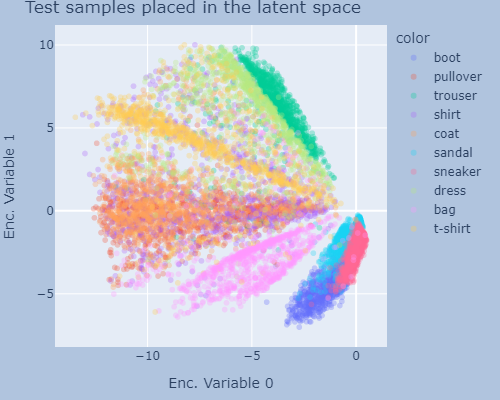

In [42]:
fig = px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()],
                 opacity=0.3,
                 width=500,
                 height=400,
                 title="Test samples placed in the latent space")

fig.update_layout(
    margin=dict(l=20, r=20, t=25, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show("png")

In [43]:
def image_generator(x,y,decoder,device):
    decoder.to(device)
    #move the input to the GPU and predict the output
    decoder.eval()
    latent_space_vector = torch.tensor([[x,y]])
    latent_space_vector.to(device)
    with torch.no_grad():
        # Encode the data
        decoded_img   = decoder(latent_space_vector)    
    return decoded_img.squeeze().cpu().numpy()

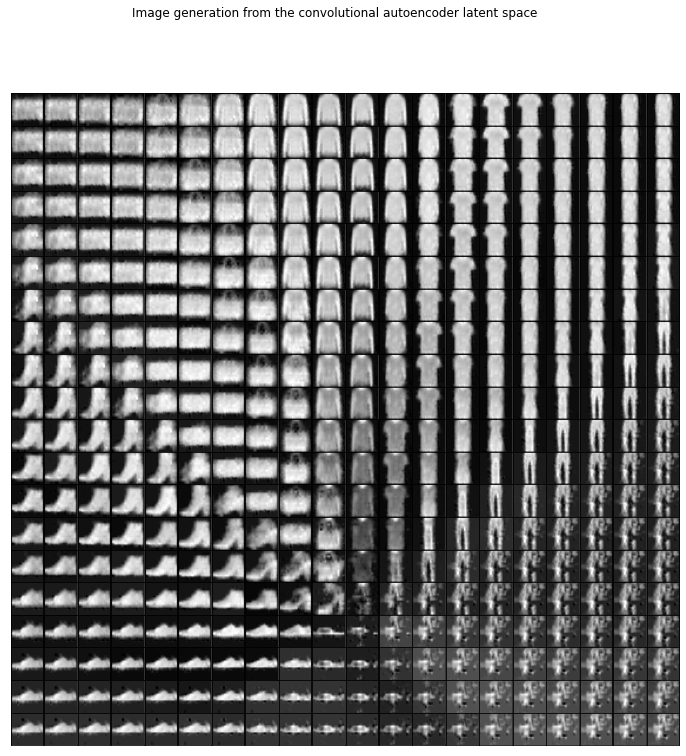

In [44]:
fig, axs = plt.subplots(20, 20, figsize=(12,12))
fig.suptitle("Image generation from the convolutional autoencoder latent space")
fig.subplots_adjust(top=0.88)
axs = axs.ravel()
X = np.linspace(-10, 2, num=20).astype(np.float32)
Y = np.linspace(-10, 10, num=20).astype(np.float32)
i = 0
for x in X:
    for y in Y: 
        img = image_generator(x,y,AE_2.decoder,device)
        axs[i].imshow(img, cmap='gist_gray')
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        i +=1
# Save figures
fig.savefig('./Img/CAE_generation.svg', format='svg')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
plt.close()

Autoencoders are not designed to generate data, the lack of this ability is closely related to the lack of regularity (order) in the latent space [Here there is a bit about it and why GANS are capable of doing so](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

# Fine tuning - Transfer learning

**1 pt - fine-tune the (convolutional) autoencoder using a supervised classification task, and compare classification accuracy and learning speed with results achieved in Homework 1**

## Data

In [45]:
#Define a validation dataset
train_percent = 0.7
n_train      = int(train_percent * len(train_dataset))
n_validation = len(train_dataset) - n_train
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [n_train, n_validation])

print('# of training samples  :',len(train_dataset))
print('# of validation samples:',len(val_dataset))
print('# of test samples      :',len(test_dataset))


# of training samples  : 42000
# of validation samples: 18000
# of test samples      : 10000


In [46]:
batch_size = 256
train_dataloader      = DataLoader(train_dataset,  batch_size=batch_size,        shuffle=True, num_workers=0)
validation_dataloader = DataLoader(val_dataset,    batch_size=len(val_dataset),  shuffle=False, num_workers=0)
test_dataloader       = DataLoader(test_dataset,   batch_size=len(test_dataset), shuffle=False, num_workers=0)


## Transfer the autoencoder encoder weights to the supervised network

In [47]:
encoded_space_dim = trial.params["encoded_space_dim"]
nf = trial.params["nf"]

In [48]:
# Initialize the old autoencoder
AE = model.Autoencoder(encoded_space_dim,nf)
# Load network parameters
AE.encoder.load_state_dict(torch.load('./Models/encoder_params.pth'))

<All keys matched successfully>

In [49]:
#Initialize the Autoencoder for fine tuning
FTAE = model.Fine_Tuned_Autoencoder(encoded_space_dim,AE)


In [50]:
FTAE

Fine_Tuned_Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=288, out_features=64, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
  (fine_tuner): Linear(in_features=10, out_features=10, bias=True)
)

In [51]:
### Disable the weight update for the trained encoder
for param_name, param in FTAE.encoder.named_parameters():
    param.requires_grad = False

### Allow weight update (training) of the last layers (linear layers)
for param in FTAE.encoder[7].parameters():
    param.requires_grad = True
    
### Allow weight update (training) of the last layers (linear layers)
for param in FTAE.encoder[9].parameters():
    param.requires_grad = True

### Check which weights and biases will be updated
for param_name, param in FTAE.encoder.named_parameters():
    print(param_name,param.requires_grad)

0.weight False
0.bias False
2.weight False
2.bias False
4.weight False
4.bias False
7.weight True
7.bias True
9.weight True
9.bias True


In [52]:
learning_rate       = 1e-3
regularization_term = 0.
n_epochs = 50

In [53]:
### Define the loss function
loss_fn = nn.CrossEntropyLoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': FTAE.encoder.parameters()},
    {'params': FTAE.fine_tuner.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=regularization_term)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


In [54]:
train, test = FTAE.tune_training_cycle(device,
                                       train_dataloader,
                                       validation_dataloader,
                                       loss_fn,
                                       optim,
                                       n_epochs,
                                       test_dataloader,
                                      verbose=False)

100%|██████████| 50/50 [07:55<00:00,  9.52s/it]


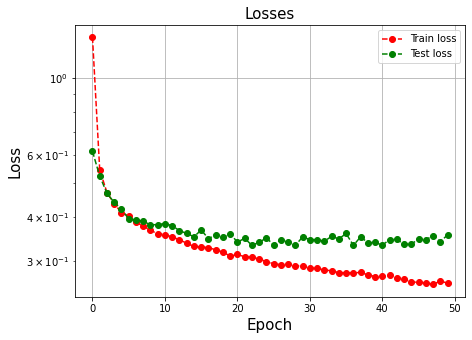

In [55]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test, linestyle='--', marker='o', color='g', label='Test loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.ylim(0,2)
plt.savefig('./Img/fine_tunning_losses.svg', format='svg')
plt.show()

In [56]:
test_acc = 0

y_test=[]
y_pred=[]

FTAE.to(device)

with torch.no_grad():
    for x_batched, y_batched in test_dataloader:
        # Move data to device
        x_batched = x_batched.to(device)
        y_batched = y_batched.to(device)

        # forward the data
        out = FTAE.forward(x_batched,"Test")

        y_test.append(y_batched)
        y_pred.append(out)

        pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
        right = np.sum(pred == np.array(y_batched.cpu()))
        test_acc = test_acc + right

print(f"The obtained accuracy is {test_acc/len(test_dataset)*100} %")

The obtained accuracy is 86.88 %


In [59]:
def confussion_plot(real, prediction):
    categories = ['T-shirt/top','Trouser','Pullover',
                    'Dress','Coat','Sandal','Shirt',
                    'Sneaker','Bag','Ankle boot']

    array = confusion_matrix(real, prediction,normalize="true")
    df_cm = pd.DataFrame(array, index = categories, columns = categories)
    
    fig = plt.figure(figsize=(8,7))
    sns.heatmap(df_cm, annot=True, fmt='.2f')
    plt.ylabel("Correct",fontsize=15)
    plt.xlabel("Predicted",fontsize=15)
    plt.title("Confussion matrix",fontsize=15)
    plt.savefig('./Img/confussion.svg', format='svg')
    plt.show()

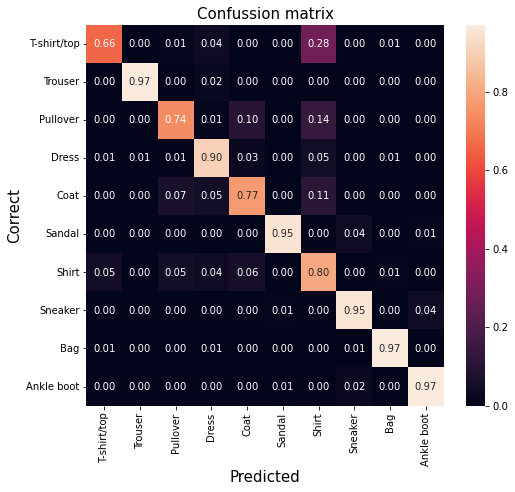

In [60]:
confussion_plot(y_batched, pred)

# Generative models


**2 pt: implement and test variational (convolutional) autoencoder or GAN or SimCLR**

## Variational Autoencoder


![LALA](./Img/variational_autoencoder.png)

[VAES by towarddatascience](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

- a variational autoencoder can be defined as being an autoencoder whose training is regularised to avoid overfitting and ensure that the latent space has good properties that enable generative process.
-  instead of encoding an input as a single point, we encode it as a distribution over the latent space.
- The model is then trained as follows:

    - first, the input is encoded as distribution over the latent space

    - second, a point from the latent space is sampled from that distribution
    
    - third, the sampled point is decoded and the reconstruction error can be computed
    - finally, the reconstruction error is backpropagated through the network

[GANS by towarddatasicence](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29)

In [14]:
encoded_space_dim = 2
max_epochs     = 50
learning_rate  = 0.0067
regularization = 0.
nf = 8

In [15]:
# Initialize the autoencoder
VAE = model.Variational_Autoencoder(encoded_space_dim, nf)

In [16]:
### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': VAE.encoder.parameters()},
    {'params': VAE.decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=regularization)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


Selected device: cpu


In [17]:
train, test = VAE.training_cycle(device,
                                 train_dataloader,
                                   test_dataloader,
                                   optim,
                                   max_epochs,
                                   test_dataset,
                                   beta = 0.8,
                                   verbose = False)


100%|██████████| 50/50 [17:33<00:00, 21.07s/it]


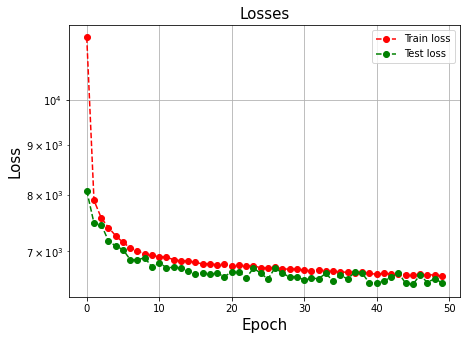

In [18]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test, linestyle='--', marker='o', color='g', label='Test loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.ylim(0,2)
plt.savefig('./Img/Variational_AE_losses.svg', format='svg')
plt.show()


In [19]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    with torch.no_grad():
        _,latent_mn,latent_std = VAE.forward(img, "Test")
        encoded_img = VAE.sampler(latent_mn,latent_std)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)

100%|██████████| 10000/10000 [00:07<00:00, 1360.97it/s]


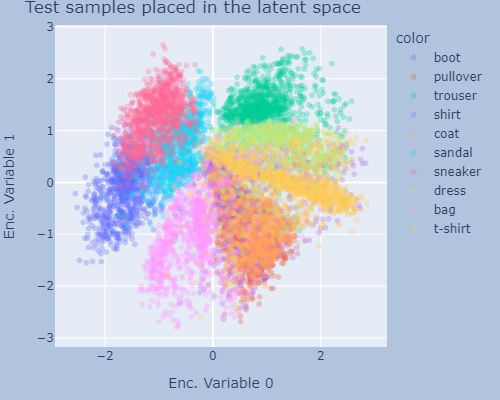

In [20]:
fig = px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()],
                 opacity=0.3,
                 width=500,
                 height=400,
                 title="Test samples placed in the latent space")

fig.update_layout(
    margin=dict(l=20, r=20, t=25, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show("png")
fig.write_image("Img/VAE_latent_space.svg")

In [22]:
def image_generator(x,y,decoder,device):
    decoder.to(device)
    #move the input to the GPU and predict the output
    decoder.eval()
    latent_space_vector = torch.tensor([[x,y]])
    latent_space_vector.to(device)
    with torch.no_grad():
        # Encode the data
        decoded_img   = decoder(latent_space_vector)    
    return decoded_img.squeeze().cpu().numpy()

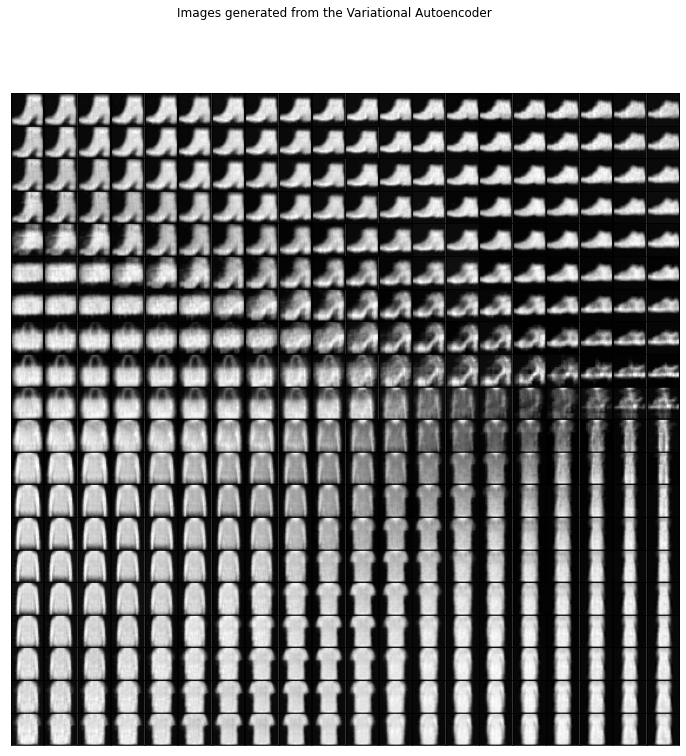

In [23]:
fig, axs = plt.subplots(20, 20, figsize=(12,12))
fig.suptitle("Images generated from the Variational Autoencoder")
fig.subplots_adjust(top=0.88)
axs = axs.ravel()
X = np.linspace(-2, 2, num=20).astype(np.float32)
Y = np.linspace(-1, 1, num=20).astype(np.float32)
i = 0
for x in X:
    for y in Y: 
        img = image_generator(x,y,VAE.decoder,device)
        axs[i].imshow(img, cmap='gist_gray')
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        i +=1
# Save figures
fig.savefig('./Img/VAE_generation.svg', format='svg')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
plt.close()

## GAN - Generative Adversarial Network

[A bit of theory](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29) and a [bit of coding](https://towardsdatascience.com/building-a-gan-with-pytorch-237b4b07ca9a). But based on [this post](https://realpython.com/generative-adversarial-networks/#the-architecture-of-generative-adversarial-networks).

Goodfellow et al., in their original paper Generative Adversarial Networks, proposed an interesting idea: use a very well-trained classifier to distinguish between a generated image and an actual image. If such a classifier exists, we can create and train a generator network until it can output images that can completely fool the classifier.

![LALA](./Img/GAN_pipeline.jpeg)

In [6]:
batch_size =32

### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [7]:
class Discriminator(nn.Module):
    def __init__(self,dp=0.3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(dp),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dp),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dp),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output
    
    
def sample_generator_to_train_discriminator(real_samples, device, batch_size):
    
    # Assign label 1 to real images
    real_samples = real_samples.to(device)
    real_labels  = torch.ones((batch_size,1)).to(device)
    
    # Generate some fake images
    noise_sample = torch.randn((batch_size, 100)).to(device)
    fake_samples = generator(noise_sample)
    fake_labels  = torch.zeros((batch_size, 1)).to(device)
    
    # Concatenate all the data which will serve as training dataset for the discriminator
    all_samples = torch.cat((real_samples,fake_samples))
    all_labels  = torch.cat((real_labels, fake_labels))
    
    return all_samples, all_labels,real_labels

In [8]:
learning_rate = 0.0001
regularization = 0.
num_epochs = 200


In [9]:
discriminator = Discriminator()
generator = Generator()

In [10]:
### Define the loss function
loss_fn = nn.BCELoss()

### Define an optimizer (both for the encoder and the decoder!)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
optimizer_generator     = torch.optim.Adam(generator.parameters(), lr=learning_rate)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
discriminator.to(device)
generator.to(device)

Selected device: cpu


Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [11]:
loss_discriminator_ = []
loss_generator_     = []

for epoch in tqdm(range(num_epochs)):
    for n, (real_samples, mnist_labels) in enumerate(train_dataloader):
        
        
        ### Data for training the discriminator
        all_samples,all_samples_labels,real_samples_labels = sample_generator_to_train_discriminator(real_samples, device, batch_size)

        
        ### Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator   = loss_fn(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        ### Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)  # Sample some noise to feed the generator

        ### Training the generator
        generator.zero_grad()
        generated_samples              = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        
        loss_generator = loss_fn(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            loss_batch_discriminator = loss_discriminator.detach().cpu().numpy()
            loss_batch_generator = loss_generator.detach().cpu().numpy()
            loss_discriminator_.append(loss_batch_discriminator)
            loss_generator_.append(loss_batch_generator)
            #Save model
            if (epoch % 5==0):
                torch.save(generator.state_dict(), f'./Models/GAN_generator_epoch_{epoch}.pth')
                print(f"Epoch: {epoch} Loss D.: {loss_batch_discriminator}")
                print(f"Epoch: {epoch} Loss G.: {loss_batch_generator}")

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch: 0 Loss D.: 0.6928901076316833
Epoch: 0 Loss G.: 0.4795057475566864


  2%|█▉                                                                             | 5/200 [12:02<7:54:16, 145.93s/it]

Epoch: 5 Loss D.: 0.14013734459877014
Epoch: 5 Loss G.: 2.5658886432647705


  5%|███▉                                                                          | 10/200 [24:38<7:57:16, 150.72s/it]

Epoch: 10 Loss D.: 0.40220221877098083
Epoch: 10 Loss G.: 1.7448612451553345


  8%|█████▊                                                                        | 15/200 [37:10<7:43:17, 150.26s/it]

Epoch: 15 Loss D.: 0.4620330333709717
Epoch: 15 Loss G.: 1.5551127195358276


 10%|███████▊                                                                      | 20/200 [50:15<7:36:37, 152.21s/it]

Epoch: 20 Loss D.: 0.34823375940322876
Epoch: 20 Loss G.: 1.4755096435546875


 12%|█████████▌                                                                  | 25/200 [1:02:49<7:22:24, 151.68s/it]

Epoch: 25 Loss D.: 0.4246756136417389
Epoch: 25 Loss G.: 1.6859338283538818


 15%|███████████▍                                                                | 30/200 [1:15:50<7:25:17, 157.16s/it]

Epoch: 30 Loss D.: 0.42689570784568787
Epoch: 30 Loss G.: 1.6074508428573608


 18%|█████████████▎                                                              | 35/200 [1:28:08<6:49:30, 148.92s/it]

Epoch: 35 Loss D.: 0.3404289186000824
Epoch: 35 Loss G.: 1.153576374053955


 20%|███████████████▏                                                            | 40/200 [1:40:46<6:44:12, 151.58s/it]

Epoch: 40 Loss D.: 0.37816110253334045
Epoch: 40 Loss G.: 1.7084225416183472


 22%|█████████████████                                                           | 45/200 [1:54:04<6:50:30, 158.91s/it]

Epoch: 45 Loss D.: 0.385436475276947
Epoch: 45 Loss G.: 1.214661717414856


 25%|███████████████████                                                         | 50/200 [2:07:59<6:57:24, 166.96s/it]

Epoch: 50 Loss D.: 0.4562584161758423
Epoch: 50 Loss G.: 1.864416480064392


 28%|████████████████████▉                                                       | 55/200 [2:23:02<7:16:40, 180.69s/it]

Epoch: 55 Loss D.: 0.40507039427757263
Epoch: 55 Loss G.: 1.6249816417694092


 30%|██████████████████████▊                                                     | 60/200 [2:37:56<6:54:48, 177.78s/it]

Epoch: 60 Loss D.: 0.35932907462120056
Epoch: 60 Loss G.: 1.5787490606307983


 32%|████████████████████████▋                                                   | 65/200 [2:52:01<6:23:40, 170.52s/it]

Epoch: 65 Loss D.: 0.4788506329059601
Epoch: 65 Loss G.: 1.4548453092575073


 35%|██████████████████████████▌                                                 | 70/200 [3:06:09<6:09:48, 170.68s/it]

Epoch: 70 Loss D.: 0.3663240373134613
Epoch: 70 Loss G.: 1.6272192001342773


 38%|████████████████████████████▌                                               | 75/200 [3:20:34<6:00:18, 172.95s/it]

Epoch: 75 Loss D.: 0.4078994393348694
Epoch: 75 Loss G.: 1.5624650716781616


 40%|██████████████████████████████▍                                             | 80/200 [3:34:45<5:41:37, 170.82s/it]

Epoch: 80 Loss D.: 0.38133877515792847
Epoch: 80 Loss G.: 1.270695447921753


 42%|████████████████████████████████▎                                           | 85/200 [3:50:15<5:55:14, 185.34s/it]

Epoch: 85 Loss D.: 0.49815988540649414
Epoch: 85 Loss G.: 1.513077974319458


 45%|██████████████████████████████████▏                                         | 90/200 [4:04:43<5:39:58, 185.44s/it]

Epoch: 90 Loss D.: 0.401596337556839
Epoch: 90 Loss G.: 1.8500350713729858


 48%|████████████████████████████████████                                        | 95/200 [4:19:16<5:07:20, 175.63s/it]

Epoch: 95 Loss D.: 0.3844434320926666
Epoch: 95 Loss G.: 1.9611709117889404


 50%|█████████████████████████████████████▌                                     | 100/200 [4:33:59<4:53:57, 176.38s/it]

Epoch: 100 Loss D.: 0.3597579598426819
Epoch: 100 Loss G.: 1.6343910694122314


 52%|███████████████████████████████████████▍                                   | 105/200 [4:48:52<4:51:09, 183.89s/it]

Epoch: 105 Loss D.: 0.4480992257595062
Epoch: 105 Loss G.: 1.3109254837036133


 55%|█████████████████████████████████████████▎                                 | 110/200 [5:03:35<4:23:50, 175.90s/it]

Epoch: 110 Loss D.: 0.40295159816741943
Epoch: 110 Loss G.: 1.7286391258239746


 57%|███████████████████████████████████████████▏                               | 115/200 [5:18:35<4:13:19, 178.81s/it]

Epoch: 115 Loss D.: 0.31460535526275635
Epoch: 115 Loss G.: 1.4944911003112793


 60%|█████████████████████████████████████████████                              | 120/200 [5:31:57<3:32:03, 159.05s/it]

Epoch: 120 Loss D.: 0.4996550977230072
Epoch: 120 Loss G.: 1.6402913331985474


 62%|██████████████████████████████████████████████▉                            | 125/200 [5:48:13<3:53:32, 186.83s/it]

Epoch: 125 Loss D.: 0.3034213185310364
Epoch: 125 Loss G.: 1.5658897161483765


 65%|████████████████████████████████████████████████▊                          | 130/200 [6:02:33<3:23:29, 174.41s/it]

Epoch: 130 Loss D.: 0.29936718940734863
Epoch: 130 Loss G.: 1.5150660276412964


 68%|██████████████████████████████████████████████████▋                        | 135/200 [6:17:00<3:08:23, 173.91s/it]

Epoch: 135 Loss D.: 0.4761194884777069
Epoch: 135 Loss G.: 1.8155051469802856


 70%|████████████████████████████████████████████████████▌                      | 140/200 [6:31:34<2:50:41, 170.69s/it]

Epoch: 140 Loss D.: 0.36370518803596497
Epoch: 140 Loss G.: 1.6940847635269165


 72%|██████████████████████████████████████████████████████▍                    | 145/200 [6:45:20<2:38:41, 173.12s/it]

Epoch: 145 Loss D.: 0.33634766936302185
Epoch: 145 Loss G.: 1.554060459136963


 75%|████████████████████████████████████████████████████████▎                  | 150/200 [6:59:42<2:26:47, 176.16s/it]

Epoch: 150 Loss D.: 0.29738837480545044
Epoch: 150 Loss G.: 1.592291235923767


 78%|██████████████████████████████████████████████████████████▏                | 155/200 [7:14:34<2:11:05, 174.79s/it]

Epoch: 155 Loss D.: 0.4195873737335205
Epoch: 155 Loss G.: 1.9332656860351562


 80%|████████████████████████████████████████████████████████████               | 160/200 [7:28:01<1:46:02, 159.07s/it]

Epoch: 160 Loss D.: 0.31840527057647705
Epoch: 160 Loss G.: 1.895764946937561


 82%|█████████████████████████████████████████████████████████████▉             | 165/200 [7:39:55<1:25:04, 145.86s/it]

Epoch: 165 Loss D.: 0.44831112027168274
Epoch: 165 Loss G.: 1.7793071269989014


 85%|███████████████████████████████████████████████████████████████▊           | 170/200 [7:51:07<1:08:00, 136.01s/it]

Epoch: 170 Loss D.: 0.2145729959011078
Epoch: 170 Loss G.: 1.8061716556549072


 88%|█████████████████████████████████████████████████████████████████▋         | 175/200 [8:15:21<1:33:48, 225.13s/it]

Epoch: 175 Loss D.: 0.30603086948394775
Epoch: 175 Loss G.: 1.6848481893539429


 90%|███████████████████████████████████████████████████████████████████▌       | 180/200 [8:30:00<1:01:17, 183.87s/it]

Epoch: 180 Loss D.: 0.4427001476287842
Epoch: 180 Loss G.: 1.6131031513214111


 92%|███████████████████████████████████████████████████████████████████████▏     | 185/200 [8:44:27<44:04, 176.30s/it]

Epoch: 185 Loss D.: 0.3406544029712677
Epoch: 185 Loss G.: 2.1331100463867188


 95%|█████████████████████████████████████████████████████████████████████████▏   | 190/200 [8:58:48<28:11, 169.10s/it]

Epoch: 190 Loss D.: 0.3473951816558838
Epoch: 190 Loss G.: 1.7671902179718018


 98%|███████████████████████████████████████████████████████████████████████████  | 195/200 [9:10:47<12:16, 147.31s/it]

Epoch: 195 Loss D.: 0.3366374671459198
Epoch: 195 Loss G.: 1.589280128479004


100%|█████████████████████████████████████████████████████████████████████████████| 200/200 [9:24:04<00:00, 169.22s/it]


### Losses

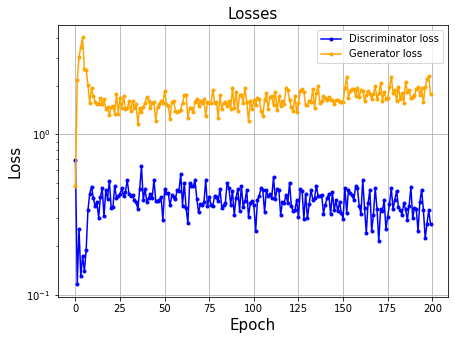

In [29]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(loss_discriminator_, linestyle='-', marker='.', color='b', label='Discriminator loss')
plt.semilogy(loss_generator_, linestyle='-', marker='.', color='orange', label='Generator loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.savefig('./imgs/classification/losses.svg', format='svg')
plt.show()

### Image generation

In [1]:
import imageio
from IPython.display import Image

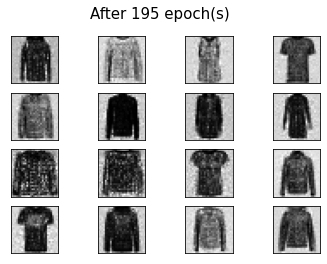

In [16]:
every_n = [i for i in range(num_epochs)]
for j in every_n[::5]:
    # Load network parameters
    generator.load_state_dict(torch.load(f'Models/GAN_generator_epoch_{j}.pth'))

    latent_space_samples = torch.randn(batch_size, 100).to(device)
    generated_samples = generator(latent_space_samples)

    generated_samples = generated_samples.cpu().detach()
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
        plt.xticks([])
        plt.yticks([])
    plt.suptitle(f'After {j} epoch(s)',fontsize=15)    
    plt.savefig(f"./Img/GAN/{j}.png")

In [2]:
# Build GIF
every_n = [i for i in range(200)]
gif_files = [f"./Img/GAN/{j}.png" for j in every_n[::5]]
with imageio.get_writer('./Img/GAN.gif', mode='I') as writer:
    for filename in gif_files:
        image = imageio.imread(filename)
        writer.append_data(image)
    
gif = imageio.mimread('./Img/GAN.gif')
gif_speed_up = './Img/GAN.gif'
imageio.mimsave(gif_speed_up, gif, fps=2)


In [3]:
Image(url='./Img/GAN.gif')  

### CGAN

In [41]:
test = nn.Conv2d(in_channels = 1,    # First convolutional layer
                      out_channels = 8,
                      kernel_size=3, 
                      stride=2,
                      padding=2)

In [35]:
for n, (real_samples, mnist_labels) in enumerate(train_dataloader):
    real_samples

In [38]:
real_samples[0].shape

torch.Size([1, 28, 28])

In [42]:
test(real_samples[0]).shape

torch.Size([8, 15, 15])